Model selection is the task of selecting a statistical model from a set of candidate models, given data. In the simplest cases, a pre-existing set of data is considered. Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice.

The data is available in Google BigQuery that can be downloaded from here. The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

In [118]:
!pip install -U gensim
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [119]:
df = pd.read_csv('data/finaldata.csv')
df = df[pd.notnull(df['category'])]
df.head(10)

,category,text
0,aadhar,are unique identification authority of india t...
1,aadhar,andis unique identification authority of india...
2,aadhar,ard 4641 hrd unique identification authority o...
3,aadhar,hdo'd government of india jddlo fifur hargun s...
4,aadhar,unique identification authority of india 9di: ...
5,aadhar,uniqui idei ntif ication nuthorvyof-india addr...
6,aadhar,unique identification authority of india ane a...
7,aadhar,7/40/ble 14 utille wot â‚¬iss sl6s nah 9661/10...
8,aadhar,government of india aadhaar ard 311817 4e917 n...
9,aadhar,- government of indja wandor arjun kumar shaw ...


In [120]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

1458045

We have over 10 million words in the data.

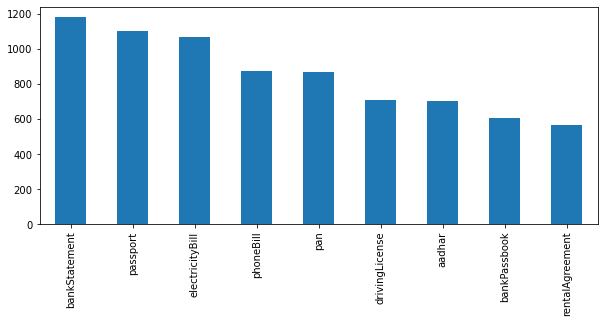

In [121]:
my_tags = ['bankStatement','passport','electricityBill','phoneBill','pan','drivingLicense','aadhar','bankPassbook','rentalAgreement']
plt.figure(figsize=(10,4))
df.category.value_counts().plot(kind='bar');

The classes are very well balanced.

In [122]:
def print_plot(index):
    example = df[df.index == index][['text', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

Have a look a few post and tag pairs.

In [123]:
print_plot(10)

hrd government of india ramprasath perumal dob: 25/08/1987 91,5001 / male 6528 8440 3803 
Tag: aadhar


In [124]:
print_plot(30)

government of india aadhaar hrd hran te917 ot 741Â°t n. ft 789 unique identification authority of india 96717 ot thin 317-41157 gri sta d i government of india te (o) sitterft the grt all 97#1 aih enrolment no.: 0000/00280/19073 information to aadhaar is a proof of identity, not of citizenship. trit to establish identity, authenticate online. naresh mali maliyon ki dhani this is electronically generated letter. bhinmal bhinmal 3itetr der str ai hou fice i jalor rajasthan - 343029 8879024962 31teir ai 3ile of 301d # 342100 i aadhaar is valid throughout the country . aadhaar will be helpful in availing government and non-government services in future . signature not verified india 03 cation 15:26:32 / your aadhaar no. : 6656 3779 8086 #2t 3iteir #a 482101 x hrd government of india unique identification authority of india address: ttt: t #17f maliyon ki dhani, bhinmal, jalor, # a grir, naresh mali rajasthan 343029 pigfett 343029 g-t aft/dob: 11/03/1994 954/ male 6656 3779 8086 6656 3779 8

The text need to be cleaned up.

In [128]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [126]:
df['text'] = df['text'].apply(clean_text)

In [127]:
print_plot(10)

hrd government india ramprasath perumal dob 25 08 1987 91 5001 male 6528 8440 3803
Tag: aadhar


Way better!

In [129]:
df['text'].apply(lambda x: len(x.split(' '))).sum()

1288189

Now we have over 3 million words to work with.

In [130]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [131]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [132]:
%%time
print(my_tags)
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

['bankStatement', 'passport', 'electricityBill', 'phoneBill', 'pan', 'drivingLicense', 'aadhar', 'bankPassbook', 'rentalAgreement']
accuracy 0.921372719374457
                 precision    recall  f1-score   support

  bankStatement       0.99      0.95      0.97       230
       passport       0.99      0.51      0.68       177
electricityBill       0.77      0.99      0.86       369
      phoneBill       0.99      0.99      0.99       204
            pan       0.89      0.96      0.92       300
 drivingLicense       0.99      0.96      0.97       273
         aadhar       0.95      0.99      0.97       322
   bankPassbook       0.97      0.90      0.93       267
rentalAgreement       0.99      0.84      0.91       160

       accuracy                           0.92      2302
      macro avg       0.95      0.90      0.91      2302
   weighted avg       0.93      0.92      0.92      2302

CPU times: user 383 ms, sys: 0 ns, total: 383 ms
Wall time: 382 ms


### Linear support vector machine

In [133]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [134]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9578627280625543
                 precision    recall  f1-score   support

  bankStatement       0.95      0.98      0.96       230
       passport       0.96      0.84      0.90       177
electricityBill       0.89      0.98      0.94       369
      phoneBill       0.98      0.99      0.98       204
            pan       0.97      0.96      0.96       300
 drivingLicense       0.99      0.96      0.97       273
         aadhar       0.97      0.99      0.98       322
   bankPassbook       0.97      0.95      0.96       267
rentalAgreement       0.99      0.91      0.95       160

       accuracy                           0.96      2302
      macro avg       0.96      0.95      0.96      2302
   weighted avg       0.96      0.96      0.96      2302

CPU times: user 368 ms, sys: 7.66 ms, total: 375 ms
Wall time: 375 ms


### Logistic regression

In [135]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [136]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9674196350999131
                 precision    recall  f1-score   support

  bankStatement       0.99      0.97      0.98       230
       passport       0.95      0.95      0.95       177
electricityBill       0.97      0.96      0.97       369
      phoneBill       0.98      0.99      0.98       204
            pan       0.95      0.97      0.96       300
 drivingLicense       0.99      0.96      0.98       273
         aadhar       0.92      0.99      0.96       322
   bankPassbook       0.98      0.97      0.98       267
rentalAgreement       0.99      0.93      0.96       160

       accuracy                           0.97      2302
      macro avg       0.97      0.97      0.97      2302
   weighted avg       0.97      0.97      0.97      2302

CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 408 ms


In [143]:
#import joblib
from joblib import dump

# dump the pipeline model
dump(logreg, filename="models/logreg_text_classification.pkl")

['models/logreg_text_classification.pkl']

In [154]:
# import joblib
from joblib import load

# sample tweet text
text = ["/ uatray foren / / name of father / legal guardian l5982212 goutam kumar datta wiren 051 / name of mother lipika datta ufa 2011 yean / name of spouse /address 15, bharati niketan,2nd crs, manjunatha lyt anandpura kr puram, bangalore pin: 560036, karnataka, india gerÃ¡ en - afte elt para / old passport no. with date and place of issue no. bn2067263296713 "]

# load the saved pipleine model
logregmodel = load("models/logreg_text_classification.pkl")

# predict on the sample tweet text
prediction=logregmodel.predict(text)
print(prediction)
print(type(prediction))
class_list=prediction.tolist()
print(class_list,type(class_list))

['passport']
<class 'numpy.ndarray'>
['passport'] <class 'list'>


The common way is to average the two word vectors. BOW based approaches which includes averaging.

### Doc2vec and Logistic Regression

Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space.

In [47]:
!pip install tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim 
from gensim.models.doc2vec import TaggedDocument
import re

In [48]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.category, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [50]:
all_data[:2]

[TaggedDocument(words=['bureau', 'e', 'turiou', 'republic', 'india', 'country', 'code', 'passport', 'p', 'ind', 'h', '4744495', '34114', 'surname', 'perumal', '451', 'name', 'father', 'legal', 'guardian', 'perumal', 'bharath', 'fern', 'given', 'name', 'anantha', 'krishna', '45t', 'name', 'mother', 'nationality', 'fein', 'sex', 'birth', 'perumal', 'kaustubha', 'indian', '14', '12', '1988', 'una', '451', 'name', 'spouse', 'place', 'birth', 'ramachandrapuram', 'gitr', 'set', '451', 'frith', 'place', 'issue', 'hig', '373', 'road', '11', 'phase1', 'hyderabad', 'bath', 'extension', 'bhel', 'ramachandrapuram', 'gitr', 'axx', 'fara', 'date', 'issue', 'un', 'fara', 'date', 'expiry', '04', '08', '2009', '03', '08', '2019', 'hyderabad', '502032', '451', 'gitr', 'fara', 'vzi', 'old', 'passport', 'date', 'place', 'issue', 'file', 'hyda03487309', 'smanths'], tags=['Train_0']),
 TaggedDocument(words=['airtel', 'relationship', 'number', '1029581857', 'airtel', 'mobile', 'number', '9910992176', 'charge

In [51]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 7672/7672 [00:00<00:00, 920417.04it/s]


In [52]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 7672/7672 [00:00<00:00, 992128.64it/s]


In [53]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [54]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [55]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, n_jobs=1)

In [56]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [57]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9218071242397915
                 precision    recall  f1-score   support

  bankStatement       0.93      0.95      0.94       225
       passport       0.83      0.81      0.82       176
electricityBill       0.92      0.92      0.92       347
      phoneBill       0.88      0.96      0.92       216
            pan       0.95      0.96      0.96       314
 drivingLicense       0.94      0.91      0.93       243
         aadhar       0.97      0.93      0.95       333
   bankPassbook       0.92      0.92      0.92       274
rentalAgreement       0.89      0.89      0.89       174

       accuracy                           0.92      2302
      macro avg       0.92      0.92      0.92      2302
   weighted avg       0.92      0.92      0.92      2302



### BOW with keras

In [58]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [59]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 5370
Test size: 2302


In [82]:
train_posts = df['text']
train_tags = df['category']
test_posts = df['text']
test_tags = df['category']
print(set(train_tags))
print(set(test_tags))

{'pan', 'aadhar', 'phoneBill', 'drivingLicense', 'bankStatement', 'passport', 'electricityBill', 'rentalAgreement', 'bankPassbook'}
{'pan', 'aadhar', 'phoneBill', 'drivingLicense', 'bankStatement', 'passport', 'electricityBill', 'rentalAgreement', 'bankPassbook'}


In [83]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [84]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [86]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [87]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [88]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (7672, 1000)
x_test shape: (7672, 1000)
y_train shape: (7672, 9)
y_test shape: (7672, 9)


In [104]:
batch_size = 32
epochs =100

In [105]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [106]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 6904 samples, validate on 768 samples
Epoch 1/100
6904/6904 [==============================] - 2s 219us/step - loss: 0.3426 - accuracy: 0.9277 - val_loss: 5.1186 - val_accuracy: 0.2513
Epoch 2/100
6904/6904 [==============================] - 1s 196us/step - loss: 0.1297 - accuracy: 0.9719 - val_loss: 5.8108 - val_accuracy: 0.2513
Epoch 3/100
6904/6904 [==============================] - 1s 177us/step - loss: 0.0963 - accuracy: 0.9790 - val_loss: 6.4840 - val_accuracy: 0.2500
Epoch 4/100
6904/6904 [==============================] - 1s 189us/step - loss: 0.0753 - accuracy: 0.9819 - val_loss: 6.9144 - val_accuracy: 0.2513
Epoch 5/100
6904/6904 [==============================] - 2s 249us/step - loss: 0.0635 - accuracy: 0.9852 - val_loss: 7.4891 - val_accuracy: 0.2513
Epoch 6/100
6904/6904 [==============================] - 1s 185us/step - loss: 0.0630 - accuracy: 0.9870 - val_loss: 7.6297 - val_accuracy: 0.2513
Epoch 7/100
6904/6904 [==============================] - 1s 189us/step 

In [107]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

7672/7672 [==============================] - 0s 46us/step
Test accuracy: 0.9211418032646179


In [108]:
model.save('models/textclassify.h5')